# Metricas

In [2]:
from langchain import hub
from langchain.schema import StrOutputParser, Document
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import ParentDocumentRetriever
from langchain.vectorstores import FAISS
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_ollama import OllamaLLM
from langchain.embeddings import HuggingFaceBgeEmbeddings
from concurrent.futures import ThreadPoolExecutor
from langchain.document_loaders.base import BaseLoader
from langchain.docstore.document import Document
from typing import List, Optional
from functools import lru_cache
from langchain.storage import InMemoryStore
import time
import re
import os
import pandas as pd


In [10]:
carpeta = "exps 6-9"

tematica_columna = [
    "Temática", "Factuales", "Factuales", "Factuales", "Temática",
    "Factuales", "Factuales", "Factuales", "Factuales", "Temática",
    "Temática"
]

# Métricas
columnas_numericas = [
    "Puntuación",
    "Puntuación_faithfulness",
    "Puntuación_coverage",
    "Puntuación_fluency"
]

resumen_por_archivo = {}

def escalar_a_100(x, maximo, minimo=1):
    return ((x - minimo) / (maximo - minimo)) * 99 + 1

# Leer y procesar archivos
for archivo in os.listdir(carpeta):
    if archivo.startswith("evaluacion") and archivo.endswith(".xlsx"):
        path = os.path.join(carpeta, archivo)
        try:
            df = pd.read_excel(path)

            if len(df) != len(tematica_columna):
                print(f"{archivo}: longitud inesperada, se esperaban {len(tematica_columna)} filas.")
                continue

            df["Temática"] = tematica_columna
            medias = df.groupby("Temática")[columnas_numericas].mean()

            fila = {}
            for col in columnas_numericas:
                if archivo.startswith("evaluacion_1_3_ingles_"):
                    fila[f"{col}_Factuales"] = round(escalar_a_100(medias.loc["Factuales", col], 3), 2)
                    fila[f"{col}_Temática"] = round(escalar_a_100(medias.loc["Temática", col], 3), 2)
                else:
                    fila[f"{col}_Factuales"] = round(escalar_a_100(medias.loc["Factuales", col], 5), 2)
                    fila[f"{col}_Temática"] = round(escalar_a_100(medias.loc["Temática", col], 5), 2)
        
            for tipo in ["Factuales", "Temática"]:
                context_media = (
                    fila[f"Puntuación_faithfulness_{tipo}"] +
                    fila[f"Puntuación_coverage_{tipo}"] +
                    fila[f"Puntuación_fluency_{tipo}"]
                ) / 3
                fila[f"Puntuación_context_{tipo}"] = round(context_media, 2)

            resumen_por_archivo[archivo] = fila

        except Exception as e:
            print(f"Error con {archivo}: {e}")
            continue

            
df_resumen = pd.DataFrame.from_dict(resumen_por_archivo, orient="index")
df_resumen.index.name = "Archivo"

columnas_deseadas = [
    "Puntuación_Factuales", "Puntuación_Temática",
    "Puntuación_context_Factuales", "Puntuación_context_Temática"
]
df_resumen = df_resumen[columnas_deseadas]

print(df_resumen)

print(df_resumen)

'''
# Guardar a Excel
df_resumen.to_excel("resumen_por_archivo.xlsx")

print("✅ Resumen creado en 'resumen_por_archivo.xlsx'")
'''

                                         Puntuación_Factuales  \
Archivo                                                         
evaluacion_1_3_ingles_coherencia_6.xlsx                 71.71   
evaluacion_1_3_ingles_coherencia_7.xlsx                 42.25   
evaluacion_1_3_ingles_coherencia_8.xlsx                 50.50   
evaluacion_1_3_ingles_coherencia_9.xlsx                 43.43   
evaluacion_español_6.xlsx                               61.11   
evaluacion_español_7.xlsx                               46.96   
evaluacion_español_8.xlsx                               50.50   
evaluacion_español_9.xlsx                               57.57   
evaluacion_ingles_coherencia_6.xlsx                     54.04   
evaluacion_ingles_coherencia_7.xlsx                     50.50   
evaluacion_ingles_coherencia_8.xlsx                     46.96   
evaluacion_ingles_coherencia_9.xlsx                     57.57   

                                         Puntuación_Temática  \
Archivo                  

'\n# Guardar a Excel\ndf_resumen.to_excel("resumen_por_archivo.xlsx")\n\nprint("✅ Resumen creado en \'resumen_por_archivo.xlsx\'")\n'

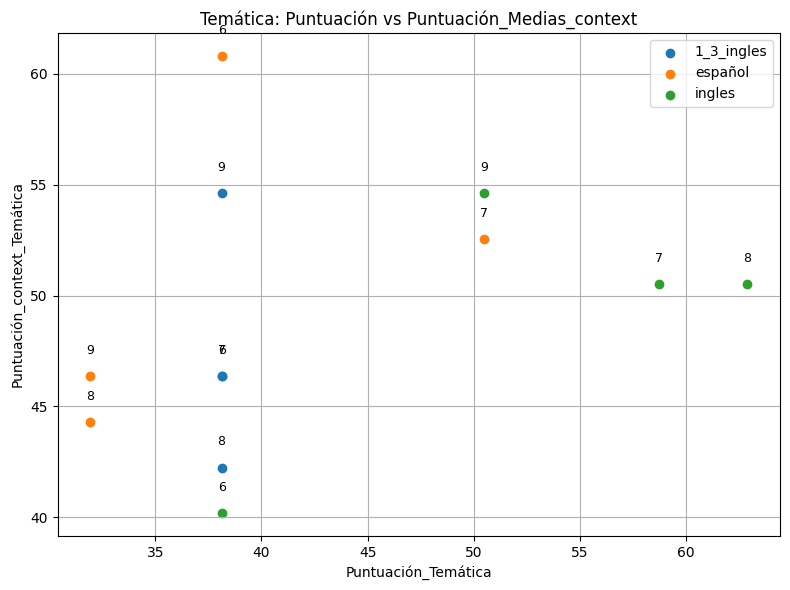

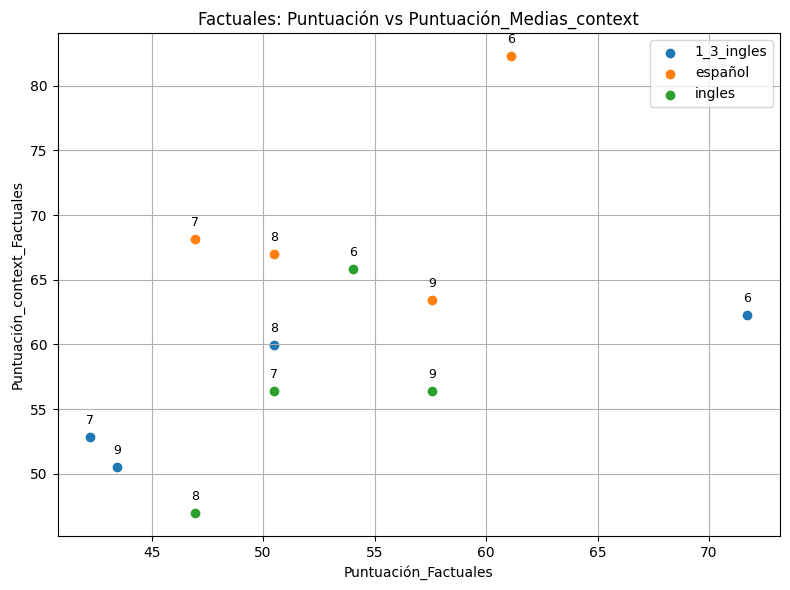

In [12]:
import matplotlib.pyplot as plt
import re

def extraer_numero(nombre_archivo):
    match = re.search(r'_(\d+)\.xlsx$', nombre_archivo)
    return match.group(1) if match else ""

def extraer_grupo(nombre):
    if nombre.startswith("evaluacion_1_3_ingles"):
        return "1_3_ingles"
    elif nombre.startswith("evaluacion_ingles"):
        return "ingles"
    elif nombre.startswith("evaluacion_español"):
        return "español"
    else:
        return "otro"


df_resumen["Grupo"] = df_resumen.index.map(extraer_grupo)
df_resumen["Numero"] = df_resumen.index.map(extraer_numero)


plt.figure(figsize=(8, 6))
for grupo in df_resumen["Grupo"].unique():
    subset = df_resumen[df_resumen["Grupo"] == grupo]
    plt.scatter(
        subset["Puntuación_Temática"],
        subset["Puntuación_context_Temática"],
        label=grupo
    )
    
    for i, row in subset.iterrows():
        plt.text(
            row["Puntuación_Temática"],
            row["Puntuación_context_Temática"] + 1,
            row["Numero"],
            ha="center",
            fontsize=9
        )

plt.title("Temática: Puntuación vs Puntuación_Medias_context")
plt.xlabel("Puntuación_Temática")
plt.ylabel("Puntuación_context_Temática")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
for grupo in df_resumen["Grupo"].unique():
    subset = df_resumen[df_resumen["Grupo"] == grupo]
    plt.scatter(
        subset["Puntuación_Factuales"],
        subset["Puntuación_context_Factuales"],
        label=grupo
    )
    for i, row in subset.iterrows():
        plt.text(
            row["Puntuación_Factuales"],
            row["Puntuación_context_Factuales"] + 1,
            row["Numero"],
            ha="center",
            fontsize=9
        )

plt.title("Factuales: Puntuación vs Puntuación_Medias_context")
plt.xlabel("Puntuación_Factuales")
plt.ylabel("Puntuación_context_Factuales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
